# TensorFlow Tutorial #19
# Hyper-Parameter Optimization

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsl1877BS8m3yt8t_wq2IWji)

## Introduction

There are many parameters you can select when building and training a Neural Network in TensorFlow. These are often called Hyper-Parameters. For example, there is a hyper-parameter for how many layers the network should have, and another hyper-parameter for how many nodes per layer, and another hyper-parameter for the activation function to use, etc. The optimization method also has one or more hyper-parameters you can select, such as the learning-rate.

One way of searching for good hyper-parameters is by hand-tuning, where you try one set of parameters and see how they perform, and then you try another set of parameters and see if they improve the performance. You try and build an intuition for what works well and guide your parameter-search accordingly. Not only is this extremely time-consuming for a human researcher, but the optimal parameters are often counter-intuitive to humans so you will not find them!

Another way of searching for good hyper-parameters is to divide each parameter's valid range into evenly spaced values, and then simply have the computer try all combinations of parameter-values. This is called Grid Search. Although it is run entirely by the computer, it quickly becomes extremely time-consuming because the number of parameter-combinations increases exponentially as you add more hyper-parameters. This problem is known as the Curse of Dimensionality. For example, if you have just 4 hyper-parameters to tune and each of them is allowed 10 possible values, then there is a total of 10^4 parameter-combinations. If you add just one more hyper-parameter then there are 10^5 parameter-combinations, and so on.

Yet another way of searching for good hyper-parameters is by random search. Instead of systematically trying every single parameter-combination as in Grid Search, we now try a number of parameter-combinations completely at random. This is like searching for "a needle in a haystack" and as the number of parameters increases, the probability of finding the optimal parameter-combinations by random sampling decreases to zero.

This tutorial uses a clever method for finding good hyper-parameters known as Bayesian Optimization. You should be familiar with TensorFlow, Keras and Convolutional Neural Networks, see Tutorials #01, #02 and #03-C.

## Flowchart

The problem with hyper-parameter optimization is that it is extremely costly to assess the performance of a set of parameters. This is because we first have to build the corresponding neural network, then we have to train it, and finally we have to measure its performance on a test-set. In this tutorial we will use the small MNIST problem so this training can be done very quickly, but on more realistic problems the training may take hours, days or even weeks on a very fast computer. So we need an optimization method that can search for hyper-parameters as efficiently as possible, by only evaluating the actual performance when absolutely necessary.

The idea with Bayesian optimization is to construct another model of the search-space for hyper-parameters. One kind of model is known as a Gaussian Process. This gives us an estimate of how the performance varies with changes to the hyper-parameters. Whenever we evaluate the actual performance for a set of hyper-parameters, we know for a fact what the performance is - except perhaps for some noise. We can then ask the Bayesian optimizer to give us a new suggestion for hyper-parameters in a region of the search-space that we haven't explored yet, or hyper-parameters that the Bayesian optimizer thinks will bring us most improvement. We then repeat this process a number of times until the Bayesian optimizer has built a good model of how the performance varies with different hyper-parameters, so we can choose the best parameters.

The flowchart of the algorithm is roughly:

![Flowchart](images/19_flowchart_bayesian_optimization.png)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

We need to import several things from Keras.

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

**NOTE:** We will save and load models using Keras so you need to have [h5py](http://docs.h5py.org/en/latest/build.html#install) installed. You also need to have [scikit-optimize](https://scikit-optimize.github.io/) installed for doing the hyper-parameter optimization.

You should be able to run the following command in a terminal to install them both:

`pip install h5py scikit-optimize`

**NOTE:** This Notebook requires plotting functions in `scikit-optimize` that have not been merged into the official release at the time of this writing. If this Notebook cannot run with the version of `scikit-optimize` installed by the command above, you may have to install `scikit-optimize` from a development branch by running the following command instead:

`pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555`

In [3]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

/home/magnus/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/magnus/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


This was developed using Python 3.6 (Anaconda) and package versions:

In [4]:
tf.__version__

'2.1.0'

In [5]:
tf.keras.__version__

'2.2.4-tf'

In [6]:
skopt.__version__

'0.4'

## Hyper-Parameters

In this tutorial we want to find the hyper-parametes that makes a simple Convolutional Neural Network perform best at classifying the MNIST dataset for hand-written digits.

For this demonstration we want to find the following hyper-parameters:

* The learning-rate of the optimizer.
* The number of fully-connected / dense layers.
* The number of nodes for each of the dense layers.
* Whether to use 'sigmoid' or 'relu' activation in all the layers.

We will use the Python package `scikit-optimize` (or `skopt`) for finding the best choices of these hyper-parameters. Before we begin with the actual search for hyper-parameters, we first need to define the valid search-ranges or search-dimensions for each of these parameters.

This is the search-dimension for the learning-rate. It is a real number (floating-point) with a lower bound of `1e-6` and an upper bound of `1e-2`. But instead of searching between these bounds directly, we use a logarithmic transformation, so we will search for the number `k` in `1ek` which is only bounded between -6 and -2. This is better than searching the entire exponential range.

In [7]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')

This is the search-dimension for the number of dense layers in the neural network. This is an integer and we want at least 1 dense layer and at most 5 dense layers in the neural network.

In [8]:
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')

This is the search-dimension for the number of nodes for each dense layer. This is also an integer and we want at least 5 and at most 512 nodes in each layer of the neural network.

In [9]:
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')

This is the search-dimension for the activation-function. This is a combinatorial or categorical parameter which can be either 'relu' or 'sigmoid'.

In [10]:
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')

We then combine all these search-dimensions into a list.

In [11]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

It is helpful to start the search for hyper-parameters with a decent choice that we have found by hand-tuning. But we will use the following parameters that do not perform so well, so as to better demonstrate the usefulness of hyper-parameter optimization: A learning-rate of 1e-5, a single dense layer with 16 nodes, and relu activation-functions.

Note that these hyper-parameters are packed in a single list. This is how `skopt` works internally on hyper-parameters. You therefore need to ensure that the order of the dimensions are consistent with the order given in `dimensions` above.

In [12]:
default_parameters = [1e-5, 1, 16, 'relu']

### Helper-function for log-dir-name

We will log the training-progress for all parameter-combinations so they can be viewed and compared using TensorBoard. This is done by setting a common parent-dir and then have a sub-dir for each parameter-combination with an appropriate name.

In [13]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given dir.

In [14]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

The MNIST data-set has now been loaded and consists of 70.000 images and class-numbers for the images. The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [15]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


Copy some of the data-dimensions for convenience.

In [16]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = data.img_shape_full

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

We use the performance on the validation-set as an indication of which choice of hyper-parameters performs the best on previously unseen data. The Keras API needs the validation-set as a tuple.

In [17]:
validation_data = (data.x_val, data.y_val)

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [18]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

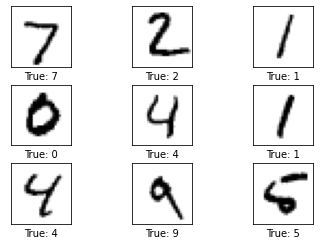

In [19]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [20]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## Hyper-Parameter Optimization

There are several steps required to do hyper-parameter optimization.

### Create the Model

We first need a function that takes a set of hyper-parameters and creates the Convolutional Neural Network corresponding to those parameters. We use Keras to build the neural network in TensorFlow, see Tutorial #03-C for more details.

In [21]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(InputLayer(input_shape=(img_size_flat,)))

    # The input from MNIST is a flattened array with 784 elements,
    # but the convolutional layers expect images with shape (28, 28, 1)
    model.add(Reshape(img_shape_full))

    # First convolutional layer.
    # There are many hyper-parameters in this layer, but we only
    # want to optimize the activation-function in this example.
    model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we only want to optimize the activation-function here.
    model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten())

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Train and Evaluate the Model

The neural network with the best hyper-parameters is saved to disk so it can be reloaded later. This is the filename for the model.

In [22]:
path_best_model = '19_best_model.h5'

This is the classification accuracy for the model saved to disk. It is a global variable which will be updated during optimization of the hyper-parameters.

In [23]:
best_accuracy = 0.0

This is the function that creates and trains a neural network with the given hyper-parameters, and then evaluates its performance on the validation-set. The function then returns the so-called fitness value (aka. objective value), which is the negative classification accuracy on the validation-set. It is negative because `skopt` performs minimization instead of maximization.

Note the function decorator `@use_named_args` which wraps the fitness function so that it can be called with all the parameters as a single list, for example: `fitness(x=[1e-4, 3, 256, 'relu'])`. This is the calling-style `skopt` uses internally.

In [24]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=data.x_train,
                        y=data.y_train,
                        epochs=3,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

### Test Run

Before we run the hyper-parameter optimization, let us first check that the various functions above actually work, when we pass the default hyper-parameters.

In [25]:
fitness(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 4s 64us/sample - loss: 2.2207 - accuracy: 0.2039 - val_loss: 2.0769 - val_accuracy: 0.3326
Epoch 2/3
55000/55000 [==============================] - 2s 39us/sample - loss: 1.8787 - accuracy: 0.4489 - val_loss: 1.5766 - val_accuracy: 0.6934
Epoch 3/3
55000/55000 [==============================] - 2s 39us/sample - loss: 1.3661 - accuracy: 0.7220 - val_loss: 1.0646 - val_accuracy: 0.8080

Accuracy: 80.80%



-0.808

### Run the Hyper-Parameter Optimization

Now we are ready to run the actual hyper-parameter optimization using Bayesian optimization from the scikit-optimize package. Note that it first calls `fitness()` with `default_parameters` as the starting point we have found by hand-tuning, which should help the optimizer locate better hyper-parameters faster.

There are many more parameters you can experiment with here, including the number of calls to the `fitness()` function which we have set to 40. But `fitness()` is very expensive to evaluate so it should not be run too many times, especially for larger neural networks and datasets.

You can also experiment with the so-called acquisition function which determines how to find a new set of hyper-parameters from the internal model of the Bayesian optimizer. You can also try using another Bayesian optimizer such as Random Forests.

In [26]:
%%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 3s 47us/sample - loss: 2.2126 - accuracy: 0.3096 - val_loss: 2.0888 - val_accuracy: 0.4494
Epoch 2/3
55000/55000 [==============================] - 2s 38us/sample - loss: 1.9393 - accuracy: 0.4852 - val_loss: 1.7300 - val_accuracy: 0.5342
Epoch 3/3
55000/55000 [==============================] - 2s 38us/sample - loss: 1.5558 - accuracy: 0.5634 - val_loss: 1.2548 - val_accuracy: 0.7250

Accuracy: 72.50%

learning rate: 7.0e-04
num_dense_layers: 1
num_dense_nodes: 365
activation: relu

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 3s 46us/sample - loss: 0.2217 - accuracy: 0.9350 - val_loss: 0.0633 - val_accuracy: 0.9828
Epoch 2/3
55000/55000 [==============================] - 2s 39us/sample - loss: 0.0576 - accuracy: 0.9822 - val_loss: 0.0507 - v

55000/55000 [==============================] - 4s 78us/sample - loss: 0.2316 - accuracy: 0.9292 - val_loss: 0.1444 - val_accuracy: 0.9592

Accuracy: 95.92%

learning rate: 3.4e-03
num_dense_layers: 3
num_dense_nodes: 5
activation: sigmoid

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 4s 64us/sample - loss: 2.3031 - accuracy: 0.1100 - val_loss: 2.3020 - val_accuracy: 0.1060
Epoch 2/3
55000/55000 [==============================] - 3s 46us/sample - loss: 2.3020 - accuracy: 0.1118 - val_loss: 2.3021 - val_accuracy: 0.1060
Epoch 3/3
55000/55000 [==============================] - 4s 70us/sample - loss: 2.3019 - accuracy: 0.1128 - val_loss: 2.3018 - val_accuracy: 0.1060

Accuracy: 10.60%

learning rate: 1.0e-02
num_dense_layers: 2
num_dense_nodes: 104
activation: relu

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 3s 52us/sample - loss: 0.1708 - accuracy: 0.9451 - val_loss:

55000/55000 [==============================] - 3s 52us/sample - loss: 2.3122 - accuracy: 0.0994 - val_loss: 2.3043 - val_accuracy: 0.0986
Epoch 3/3
55000/55000 [==============================] - 7s 121us/sample - loss: 2.3020 - accuracy: 0.1115 - val_loss: 2.3020 - val_accuracy: 0.1060

Accuracy: 10.60%

learning rate: 4.8e-04
num_dense_layers: 2
num_dense_nodes: 225
activation: sigmoid

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 3s 59us/sample - loss: 1.5780 - accuracy: 0.4531 - val_loss: 0.3782 - val_accuracy: 0.9030
Epoch 2/3
55000/55000 [==============================] - 3s 52us/sample - loss: 0.2985 - accuracy: 0.9146 - val_loss: 0.1567 - val_accuracy: 0.9564
Epoch 3/3
55000/55000 [==============================] - 7s 118us/sample - loss: 0.1712 - accuracy: 0.9491 - val_loss: 0.1077 - val_accuracy: 0.9704

Accuracy: 97.04%

learning rate: 5.5e-03
num_dense_layers: 1
num_dense_nodes: 512
activation: relu

Train on 55000

### Optimization Progress

The progress of the hyper-parameter optimization can be easily plotted. The best fitness value found is plotted on the y-axis, remember that this is the negated classification accuracy on the validation-set.

Note how few hyper-parameters had to be tried before substantial improvements were found.

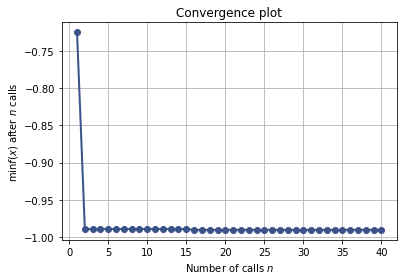

In [27]:
plot_convergence(search_result)

### Best Hyper-Parameters

The best hyper-parameters found by the Bayesian optimizer are packed as a list because that is what it uses internally.

In [28]:
search_result.x

[0.01, 2, 104, 'relu']

We can convert these parameters to a dict with proper names for the search-space dimensions.

First we need a reference to the search-space object.

In [29]:
space = search_result.space

Then we can use it to create a dict where the hyper-parameters have the proper names of the search-space dimensions. This is a bit awkward.

In [30]:
space.point_to_dict(search_result.x)

{'learning_rate': 0.01,
 'num_dense_layers': 2,
 'num_dense_nodes': 104,
 'activation': 'relu'}

This is the fitness value associated with these hyper-parameters. This is a negative number because the Bayesian optimizer performs minimization, so we had to negate the classification accuracy which is posed as a maximization problem.

In [31]:
search_result.fun

-0.9904

We can also see all the hyper-parameters tried by the Bayesian optimizer and their associated fitness values (the negated classification accuracies). These are sorted so the highest classification accuracies are shown first.

It appears that 'relu' activation was generally better than 'sigmoid'. Otherwise it can be difficult to see a pattern of which parameter choices are good. We really need to plot these results.

In [32]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.9904, [0.01, 2, 104, 'relu']),
 (-0.9894, [0.0029398096826104927, 2, 299, 'relu']),
 (-0.9892, [0.000695826471438557, 1, 365, 'relu']),
 (-0.989, [0.000658408209046353, 1, 512, 'relu']),
 (-0.989, [0.0034329866293724173, 2, 451, 'relu']),
 (-0.9882, [0.0027527776962813647, 2, 441, 'relu']),
 (-0.9878, [0.0004989932212151087, 2, 309, 'relu']),
 (-0.987, [0.009700568764470742, 3, 132, 'relu']),
 (-0.986, [0.00045720538478821585, 3, 105, 'relu']),
 (-0.9854, [0.005470139269128146, 1, 512, 'relu']),
 (-0.983, [0.0001756750312956145, 3, 512, 'relu']),
 (-0.9806, [0.00010996497783044355, 1, 512, 'relu']),
 (-0.9806, [0.0010101832379944083, 2, 512, 'sigmoid']),
 (-0.9778, [3.542177009701199e-05, 4, 512, 'relu']),
 (-0.975, [0.0014121597194479596, 1, 512, 'sigmoid']),
 (-0.9748, [5.4968307266680435e-05, 2, 512, 'relu']),
 (-0.9746, [7.662555005436298e-05, 5, 154, 'relu']),
 (-0.9734, [3.623853563736315e-05, 5, 446, 'relu']),
 (-0.9708, [0.0006699631867581338, 3, 230, 'sigmoid']),
 (-0.970

### Plots

There are several plotting functions available in the `skopt` library. For example, we can plot a histogram for the `activation` parameter, which shows the distribution of samples during the hyper-parameter optimization.

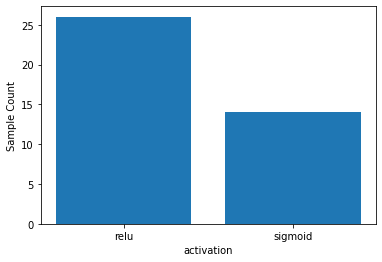

In [33]:
fig, ax = plot_histogram(result=search_result,
                         dimension_name='activation')

We can also make a landscape-plot of the estimated fitness values for two dimensions of the search-space, here taken to be `learning_rate` and `num_dense_layers`.

The Bayesian optimizer works by building a surrogate model of the search-space and then searching this model instead of the real search-space, because it is much faster. The plot shows the last surrogate model built by the Bayesian optimizer where yellow regions are better and blue regions are worse. The black dots show where the optimizer has sampled the search-space and the red star shows the best parameters found.

Several things should be noted here. Firstly, this surrogate model of the search-space may not be accurate. It is built from only 40 samples of calls to the `fitness()` function for training a neural network with a given choice of hyper-parameters. The modelled fitness landscape may differ significantly from its true values especially in regions of the search-space with few samples. Secondly, the plot may change each time the hyper-parameter optimization is run because of random noise in the training process of the neural network. Thirdly, this plot shows the effect of changing these two parameters `num_dense_layers` and `learning_rate` when averaged over all other dimensions in the search-space, this is also called a Partial Dependence plot and is a way of visualizing high-dimensional spaces in only 2-dimensions.

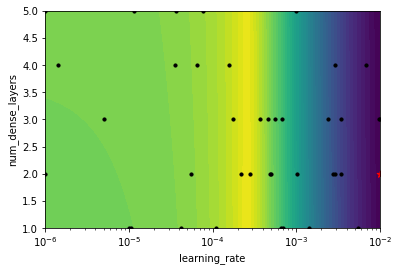

In [34]:
fig = plot_objective_2D(result=search_result,
                        dimension_name1='learning_rate',
                        dimension_name2='num_dense_layers',
                        levels=50)

We cannot make a landscape plot for the `activation` hyper-parameter because it is a categorical variable that can be one of two strings `relu` or `sigmoid`. How this is encoded depends on the Bayesian optimizer, for example, whether it is using Gaussian Processes or Random Forests. But it cannot currently be plotted using the built-in functions of `skopt`.

Instead we only want to use the real- and integer-valued dimensions of the search-space which we identify by their names.

In [35]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

We can then make a matrix-plot of all combinations of these dimensions.

The diagonal shows the influence of a single dimension on the fitness. This is a so-called Partial Dependence plot for that dimension. It shows how the approximated fitness value changes with different values in that dimension.

The plots below the diagonal show the Partial Dependence for two dimensions. This shows how the approximated fitness value changes when we are varying two dimensions simultaneously.

These Partial Dependence plots are only approximations of the modelled fitness function - which in turn is only an approximation of the true fitness function in `fitness()`. This may be a bit difficult to understand. For example, the Partial Dependence is calculated by fixing one value for the `learning_rate` and then taking a large number of random samples for the remaining dimensions in the search-space. The estimated fitness for all these points is then averaged. This process is then repeated for other values of the `learning_rate` to show how it affects the fitness on average. A similar procedure is done for the plots that show the Partial Dependence plots for two dimensions.

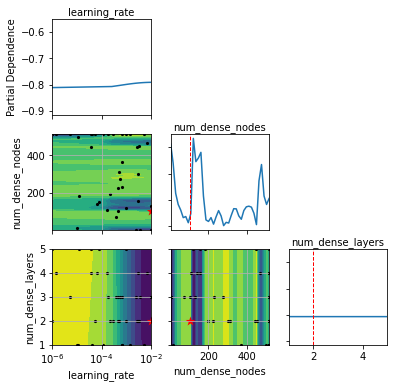

In [36]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

We can also show another type of matrix-plot. Here the diagonal shows histograms of the sample distributions for each of the hyper-parameters during the Bayesian optimization. The plots below the diagonal show the location of samples in the search-space and the colour-coding shows the order in which the samples were taken. For larger numbers of samples you will likely see that the samples eventually become concentrated in a certain region of the search-space.

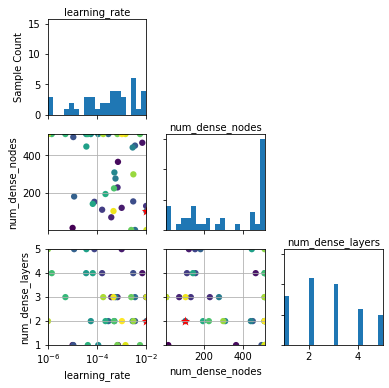

In [37]:
fig, ax = plot_evaluations(result=search_result, dimension_names=dim_names)

### Evaluate Best Model on Test-Set

We can now use the best model on the test-set. It is very easy to reload the model using Keras.

In [38]:
model = load_model(path_best_model)

We then evaluate its performance on the test-set.

In [39]:
result = model.evaluate(x=data.x_test,
                        y=data.y_test)

10000/10000 [==============================] - 1s 64us/sample - loss: 0.0490 - accuracy: 0.9882


We can print all the performance metrics for the test-set.

In [40]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.048988553384863916
accuracy 0.9882


Or we can just print the classification accuracy.

In [41]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

accuracy: 98.82%


### Predict on New Data

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [42]:
images = data.x_test[0:9]

These are the true class-number for those images. This is only used when plotting the images.

In [43]:
cls_true = data.y_test_cls[0:9]

Get the predicted classes as One-Hot encoded arrays.

In [44]:
y_pred = model.predict(x=images)

Get the predicted classes as integers.

In [45]:
cls_pred = np.argmax(y_pred,axis=1)

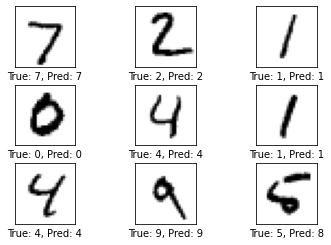

In [46]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [47]:
y_pred = model.predict(x=data.x_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

In [48]:
cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

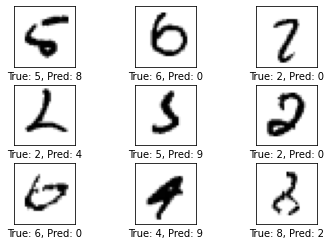

In [49]:
plot_example_errors(cls_pred)

## Conclusion

This tutorial showed how to optimize the hyper-parameters of a neural network using Bayesian optimization. We used the scikit-optimize (`skopt`) library which is still under development, but it is already an extremely powerful tool. It was able to substantially improve on hand-tuned hyper-parameters in a small number of iterations. This is vastly superior to Grid Search and Random Search of the hyper-parameters, which would require far more computational time, and would most likely find inferior hyper-parameters, especially for more difficult problems.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Try and run 100 or 200 iterations of the optimization instead of just 40 iterations. What happens to the plotted landscapes?
* Try some of the other optimization methods from scikit-optimize such as `forest_minimize` instead of `gp_minimize`. How do they perform?
* Try using another acquisition function for the optimizer e.g. Probability of Improvement.
* Try optimizing more hyper-parameters with the Bayesian optimization. For example, the kernel-size and number of filters in the convolutional-layers, or the batch-size used in training.
* Add a hyper-parameter for the number of convolutional layers and implement it in `create_model()`. Note that if you have pooling-layers after the convolution then the images are downsampled, so there is a limit to the number of layers you can have before the images become too small.
* Look at the plots. Do you think that some of the hyper-parameters may be irrelevant? Try and remove these parameters and redo the optimization of the remaining hyper-parameters.
* Use another and more difficult dataset with image-files.
* Train for more epochs. Does it improve the classification accuracy on the validiation- and test-sets? How does it affect the time-usage?
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.